In [1]:
%run gravwell-lib.ipynb

# Tables
Here is a basic table query:

In [2]:
table = query("tag=pinger ax | stats mean(ms) as ms by host ip | table protocol host ip ms", "-1h")
table

,protocol,host,ip,ms
0,ICMP,resolver1.opendns.com,208.67.222.222,2.201564
1,ICMP,www.gravwell.io,199.60.103.2,1.406499
2,ICMP,one.one.one.one,1.1.1.1,1.336061
3,ICMP,dns.google,8.8.8.8,1.773654
4,ICMP,ns1.google.com,216.239.32.10,9.960272
5,ICMP,dns9.quad9.net,149.112.112.9,0.729415


# Charts
Now let's run a query using the chart renderer. Note that we call the same function as before: `query`.

In [63]:
chart = query("tag=pinger ax | stats mean(ms) by host | chart mean by host", "-1h")
chart

,Timestamp,dns.google,dns9.quad9.net,ns1.google.com,one.one.one.one,resolver1.opendns.com,www.gravwell.io
0,2022-07-19 22:37:37.718750+00:00,1.775643,0.776961,9.683884,1.347853,2.230959,1.357453


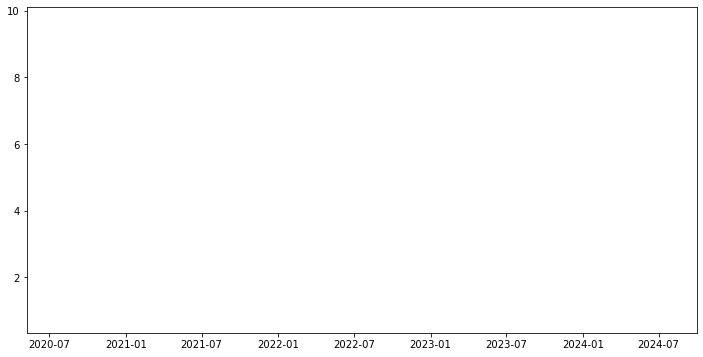

In [62]:
chart = query("tag=pinger ax | stats mean(ms) by host | chart mean by host", "-1h")
plt.figure(figsize=(12,6))
for column_name in chart.set_index("Timestamp"):
    plt.plot(chart["Timestamp"],chart[column_name])

If we're not interested in timeseries data, it makes more sense to plot the results of the table renderer, for example when doing a pie chart:

<AxesSubplot:ylabel='count'>

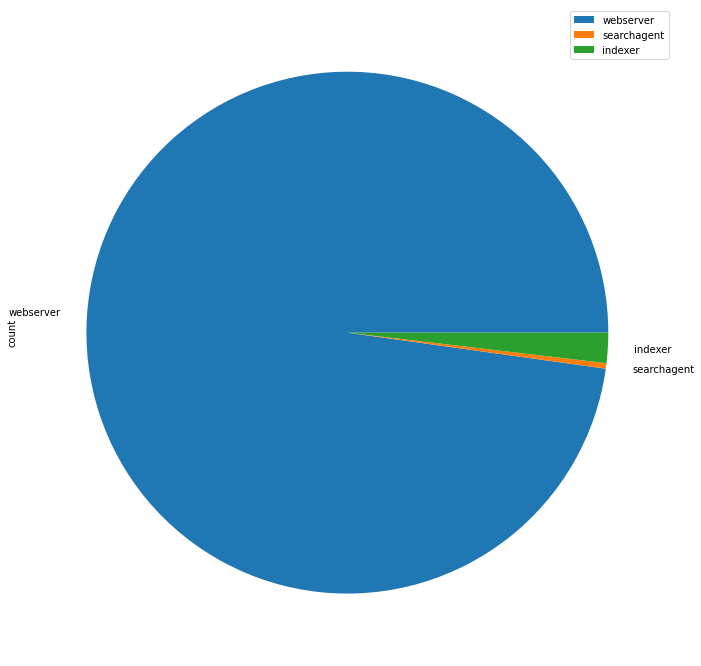

In [43]:
table.set_index("Appname").plot.pie(y="count", figsize=(12, 12))

# Raw Entries
Of course we can also just pull back the raw entries:

In [25]:
raw = query("tag=gravwell limit 10", "-1h")
for x in raw["Data"]:
    print(x)

<15>1 2022-07-19T12:42:53.799524-07:00 thufir webserver 0 - [gw@1 host="127.0.0.1" method="GET" url="/api/tags" status="200" useragent="Mozilla/5.0 (X11; Linux x86_64; rv:102.0) Gecko/20100101 Firefox/102.0" elapsed="0ms"]
<15>1 2022-07-19T12:42:53.470726-07:00 thufir webserver 0 - [gw@1 host="127.0.0.1" method="GET" url="/api/flows?admin=true" status="200" useragent="GravwellSearchAgent-5.0.5" elapsed="3ms"]
<15>1 2022-07-19T12:42:53.466833-07:00 thufir webserver 0 - [gw@1 host="127.0.0.1" method="GET" url="/api/scheduledsearches/all?admin=true" status="200" useragent="GravwellSearchAgent-5.0.5" elapsed="1ms"]
<15>1 2022-07-19T12:42:53.465233-07:00 thufir webserver 0 - [gw@1 host="127.0.0.1" method="PUT" url="/api/scheduledsearches/checkin?admin=true" status="200" useragent="GravwellSearchAgent-5.0.5" elapsed="0ms"]
<15>1 2022-07-19T12:42:51.461342-07:00 thufir webserver 0 - [gw@1 host="127.0.0.1" method="GET" url="/api/flows?admin=true" status="200" useragent="GravwellSearchAgent-5.0